# Outlier Detection using Mahalanobis Distance

In this notebook, we will be exploring how to do outlier detection.  We will use the `boston` dataset to do this.

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2

In [30]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
                'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston = pd.read_csv(data_url, sep = "\s+", skiprows = 22, header = None)
boston_flattened = boston.values.flatten()
boston = pd.DataFrame(
    boston_flattened[~np.isnan(boston_flattened)].reshape(-1, len(column_names)),
    columns = column_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


One common outlier detection methods is the use of boxplots, where any point outside the whiskers of the boxplot (or outside the inter-quartile range of the boxplot) is considered an outlier.

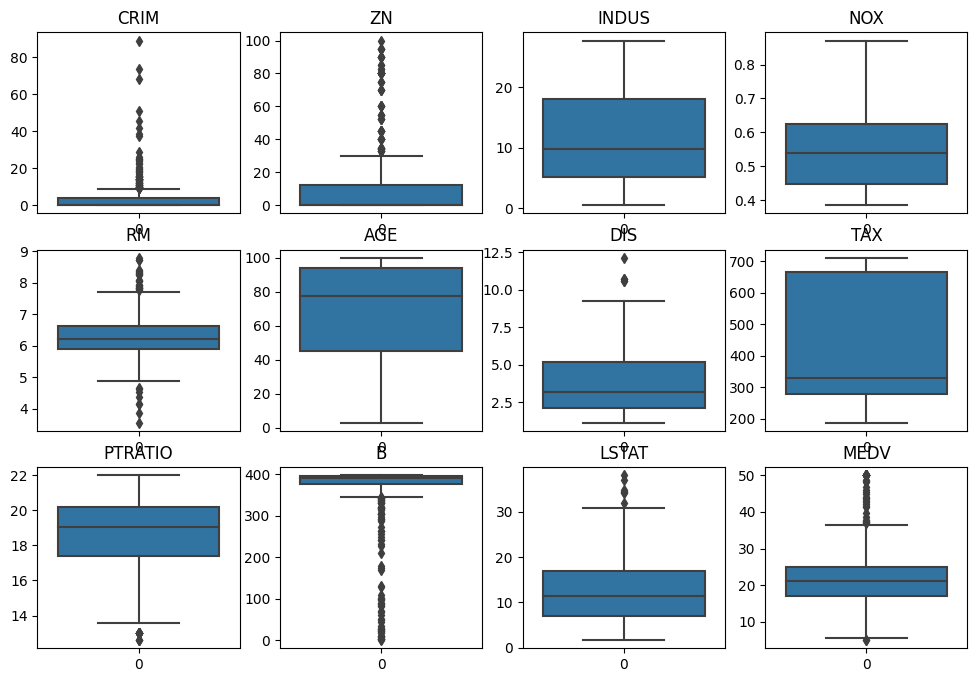

In [31]:
fig, boxplots = plt.subplots(3, 4, figsize = (12,8))
boxplot_columns = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
for i in range(len(boxplot_columns)):
    sns.boxplot(boston[boxplot_columns[i]], ax = boxplots[i // 4, i % 4]).set_title(boxplot_columns[i])

According to the boxplots, quite a few features have quite a few outliers.  If we were filtering out every observation that contains a value that is outside of the column's boxplot, we would be filtering out a lot of data.  The challenge with using boxplots to visualize outliers is that they only show outliers relative to the feature that the boxplot represents.  However, features that appear to have outliers based on their boxplot could make sense when compared to other features and their observations.  For example, let's say we have feature $x = [1,2,3,4,100]$ and feature $y = [2,4,6,8,200]$.  When looked at alone, $x = 100$ appears to be a clear outlier in the $x$ set.  But when we compare $x$ and $y$ together, we can see that they form a clear line of $y = 2x$, and there are no outliers.  We therefore need a method to detect outliers that considers how each feature relates to one another.

When researching multivariate outlier detection techniques, I came across [this article](https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33), which I will cite appropriately at the end.  The article talks about the **Mahalanobis Distance**, which is a "widely used distance metric for the detection of multivariate outliers".  The distance is defined as 

$d_n = \sqrt{(X_n - \mu_{x_n})C^{-1}(X_n - \mu_{x_n})^T}$

where $X_n$ is the matrix of observations (basically the matrix form of the data frame), $\mu_{x_n}$ is the matrix of column means (basically every row is the same row vector where each element of the row vector has the corresponding mean of each column), and $C$ is the covariance matrix of the dataframe.  $d_n$ is therefore a matrix whose diagonals correspond to each observations's Mahalanobis distance.

Once we have each Mahalanobis distance for each covariate, we can do a $\chi^2$ test with 14 degrees of freedom (since there are 14 features) on each distance value.  For this example, we will do the test at the 0.1% level.  A higher choice will filter more outliers, while a lower choice will allow more outliers.

Below is the function that we will use to create a filter for the `boston` dataset.  The function will calculate the Mahalanobis distances, compare each distance to the $\chi^2$ value, and if the distance is greater than the $\chi^2$ value, the function will track the position that corresponds to the row being an outlier.

In [32]:
def mahalanobis_filter(df, cutoff = 0.001):
    
    # Calculating Mahalanobis distance
    x_minus_mu = df - np.mean(df, axis = 0)
    inv_cov_matrix = np.linalg.inv(np.cov(df.values.T)) 
    distances = np.dot(np.dot(x_minus_mu, inv_cov_matrix), x_minus_mu.T)
    mahalanobis_distances = np.sqrt(distances.diagonal())
    
    # Performing chi-sq test
    outlier_pos = np.zeros(len(df)).astype(int)
    C = np.sqrt(chi2.ppf((1 - cutoff), df = df.shape[1]))
    for i, value in enumerate(mahalanobis_distances):
        if value > C:
            outlier_pos[i] = 1
    outlier_pos = np.array(outlier_pos, dtype = bool)
    return outlier_pos

outliers = mahalanobis_filter(boston, cutoff = 0.001)
print("Number of outliers: ", sum(outliers))

Number of outliers:  23


Our filter has selected 23 observations to be outliers.

It is a bit challenging to show which observations have been removed.  To conceptualize what was filtered out, I will plot a few combination pairs of features, indicating the observations that are no longer in the filtered dataset.

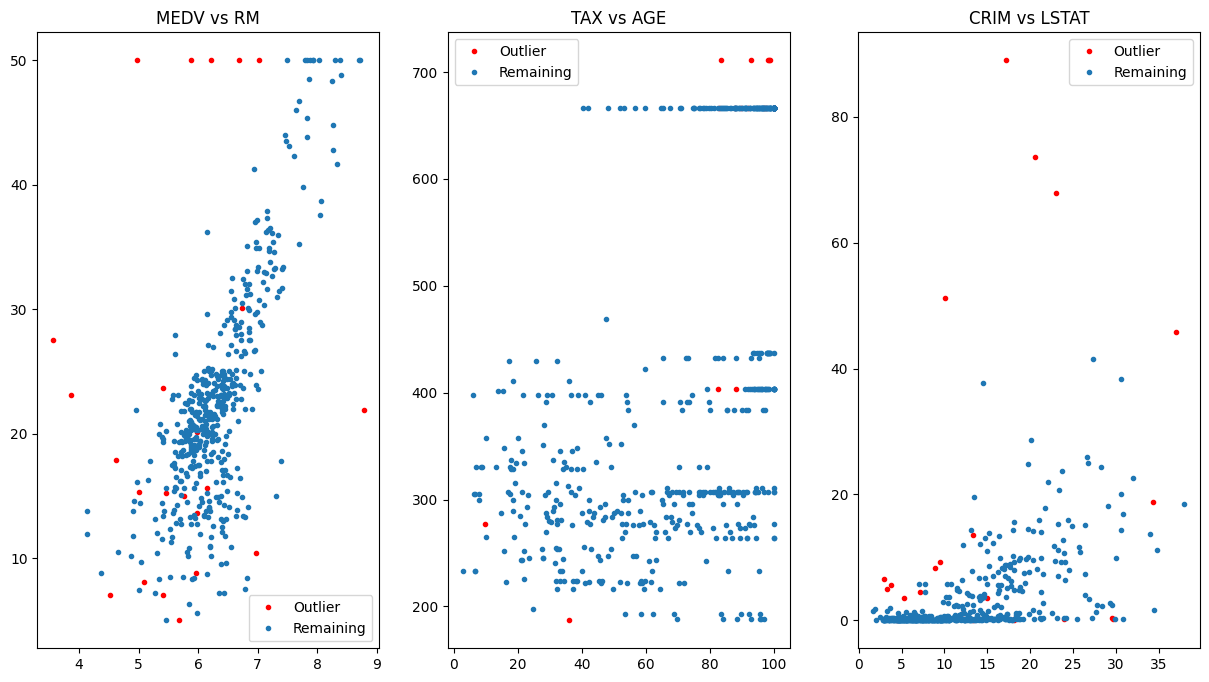

In [33]:
boston_filtered = boston[outliers == False]
boston_outliers = boston[outliers]

fig, plots = plt.subplots(1,3, figsize = (15,8))  

xcol = "RM"
ycol = "MEDV"
plots[0].plot(boston_outliers[xcol], boston_outliers[ycol], ".", color = "red")
plots[0].plot(boston_filtered[xcol], boston_filtered[ycol],  ".")
plots[0].legend(['Outlier', 'Remaining'])
plots[0].set_title(ycol + " vs " + xcol)

xcol = "AGE"
ycol = "TAX"
plots[1].plot(boston_outliers[xcol], boston_outliers[ycol], ".", color = "red")
plots[1].plot(boston_filtered[xcol], boston_filtered[ycol],  ".")
plots[1].legend(['Outlier', 'Remaining'])
plots[1].set_title(ycol +" vs " + xcol)

xcol = "LSTAT"
ycol = "CRIM"
plots[2].plot(boston_outliers[xcol], boston_outliers[ycol], ".", color = "red")
plots[2].plot(boston_filtered[xcol], boston_filtered[ycol],  ".")
plots[2].legend(['Outlier', 'Remaining'])
plots[2].set_title(ycol +" vs " + xcol);

We can see that some outliers that correspond to the feature pairs do get filtered.  `MEDV` vs `RM` removes outliers out of what appears to be a linear relationship, and `TAX` vs `AGE` and `CRIM` vs `LSTAT` appears to remove outliers that are out of range.

We also notice that there are a lot of observations being removed that do not appear to be outliers, at least according to the three plots above.  It is very likely that those observations are outliers in other pairings or combination of features that we did not choose to display.  Recall that the Mahanobis distance is comparing the distance of a point from the *overall distribution*, and not simply detecting outliers based on subsets of the data.

# References

Horsch, A. (2020, December 14). Detecting and treating outliers in python - part 2. Medium. https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 